# SRAI HW 1

*   Gautham Satyanarayana
*   Pradeep Raj



IMP : Upload 'compas-scores-two-years.csv' before running

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('compas-scores-two-years.csv')
df.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


# Fairness Metrics

## Demographic Parity

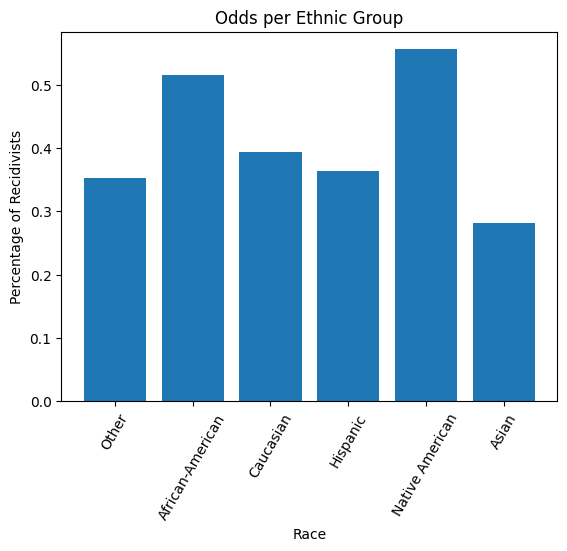

In [3]:
races = []
ps = []
for race in df['race'].unique():
    race_df = df[df['race'] == race]
    percentage = (race_df['two_year_recid'] == 1).sum() / len(race_df)
    races.append(race)
    ps.append(percentage)
    #print(f"{race} : {percentage:.2f}")
#plot
import matplotlib.pyplot as plt
plt.bar(races, ps)
plt.xlabel('Race')
plt.xticks(rotation=60)
plt.ylabel('Percentage of Recidivists')
plt.title('Odds per Ethnic Group')
plt.show()

## Equalised Odds

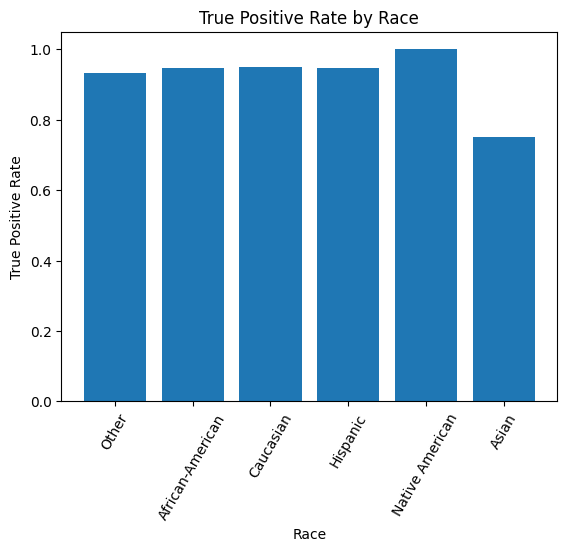

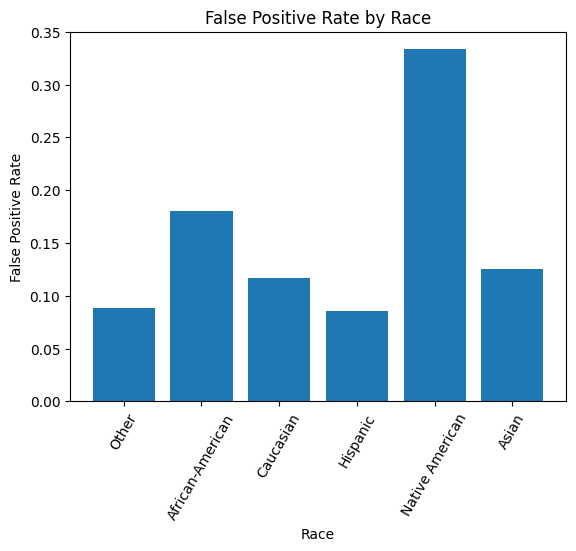

In [52]:
from sklearn.metrics import confusion_matrix
tps = []
fps = []
races = []
for race in df['race'].unique():
    race_df = df[df['race'] == race]

    tn, fp, fn, tp = confusion_matrix(race_df['event'], race_df['two_year_recid']).ravel()

    true_positive_rate = tp / (tp + fn) if (tp + fn) > 0 else 0
    false_positive_rate = fp / (fp + tn) if (fp + tn) > 0 else 0

    tps.append(true_positive_rate)
    fps.append(false_positive_rate)
    races.append(race)

    # print(f"Race: {race}")
    # print(f"  True Positive Rate: {true_positive_rate:.2f}")
    # print(f"  False Positive Rate: {false_positive_rate:.2f}")
    # print("-" * 20)

#plot multi bar graph
import matplotlib.pyplot as plt
plt.bar(races, tps, label='True Positive Rate')
plt.xlabel('Race')
plt.ylabel('True Positive Rate')
plt.title('True Positive Rate by Race')
plt.xticks(rotation=60)
plt.show()

plt.bar(races, fps, label='False Positive Rate')
plt.xlabel('Race')
plt.ylabel('False Positive Rate')
plt.title('False Positive Rate by Race')
plt.xticks(rotation=60)
plt.show()

Pradeictive Parity


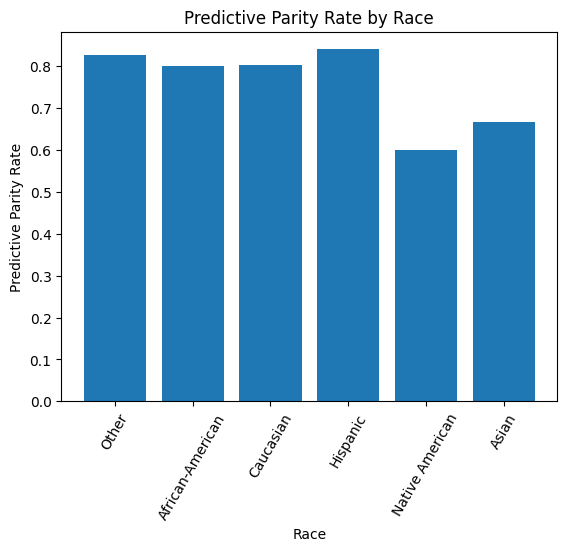

In [5]:
from sklearn.metrics import confusion_matrix

prp=[]
races=[]

for race in df['race'].unique():
  race_df=df[df['race']==race]

  tn,fp,fn,tp = confusion_matrix(race_df['event'], race_df['two_year_recid']).ravel()
  predictive_rate_parity= tp/(tp+fp) if tp+fp>0 else 0

  prp.append(predictive_rate_parity)
  races.append(race)

import matplotlib.pyplot as plt

plt.bar(races,prp, label='Predictive Rate Parity')
plt.xlabel('Race')
plt.ylabel('Predictive Parity Rate')
plt.title('Predictive Parity Rate by Race')
plt.xticks(rotation=60)
plt.show()

## Equalised Opportunity / Predictive Rate Parity

Write brief about values of TP, FP in all races

# Bias Mitigation Strategies

## Conterfactual Data Augmentation

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


df_before_mitigation=df.copy()

columns_to_drop = ["id", "name", "first", "last", "compas_screening_date", "dob", "c_case_number",
                   "r_case_number", "vr_case_number", "c_offense_date", "r_offense_date",
                   "vr_offense_date", "screening_date", "v_screening_date", "c_jail_in", "c_jail_out", "r_jail_in", "r_jail_out","v_type_of_assessment","c_arrest_date","r_days_from_arrest","violent_recid","vr_charge_degree","type_of_assessment","screening_date","in_custody","out_custody","r_charge_degree"]  # Drop date columns if unnecessary

df_before_mitigation["days_b_screening_arrest"] = df_before_mitigation["days_b_screening_arrest"].fillna(df_before_mitigation["days_b_screening_arrest"].median())
df_before_mitigation["c_days_from_compas"]=df_before_mitigation["c_days_from_compas"].fillna(df_before_mitigation["c_days_from_compas"].median())
most_common_charge = df_before_mitigation["c_charge_desc"].mode()[0]
df_before_mitigation["c_charge_desc"] = df_before_mitigation["c_charge_desc"].fillna(most_common_charge)
df_before_mitigation["vr_charge_desc"] = df_before_mitigation["vr_charge_desc"].fillna("Unknown")
df_before_mitigation["r_charge_desc"] = df_before_mitigation["r_charge_desc"].fillna("Unknown")
print(df_before_mitigation["vr_charge_desc"].isnull().sum())



df_before_mitigation.drop(columns=columns_to_drop, inplace=True, errors="ignore")

# Apply Label Encoding
categorical_cols = ["score_text", "v_score_text", "c_charge_degree", "sex","age_cat" ]
encoder = LabelEncoder()
for col in categorical_cols:
    df_before_mitigation[col] = encoder.fit_transform(df_before_mitigation[col])


#one Hot Encoding

df_before_mitigation = pd.get_dummies(df_before_mitigation, columns=["race"], drop_first=True)
df_before_mitigation = pd.get_dummies(df_before_mitigation, columns=["vr_charge_desc"], drop_first=True)
df_before_mitigation = pd.get_dummies(df_before_mitigation, columns=["r_charge_desc"], drop_first=True)
df_before_mitigation = pd.get_dummies(df_before_mitigation, columns=["c_charge_desc"], drop_first=True)


0


In [7]:
bool_cols = df_before_mitigation.select_dtypes(include="bool").columns  # Get all boolean columns
df_before_mitigation[bool_cols] = df_before_mitigation[bool_cols].astype(int)

In [8]:
# Define the target variable
y_before = df_before_mitigation["two_year_recid"]

# Define feature variables (drop non-predictive columns)
X_before = df_before_mitigation.drop(columns=["two_year_recid"])

In [9]:
from sklearn.model_selection import train_test_split

X_train_before, X_test_before, y_train_before, y_test_before = train_test_split(X_before, y_before, test_size=0.2, random_state=42)

print(f"Training Data: {X_train_before.shape}, Testing Data: {X_test_before.shape}")

Training Data: (5771, 885), Testing Data: (1443, 885)


In [10]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest model
model_before = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
model_before.fit(X_train_before, y_train_before)

print("Model Training Complete (Before Bias Mitigation)")

Model Training Complete (Before Bias Mitigation)


In [11]:
from sklearn.metrics import accuracy_score, classification_report

# Predict on the test set
y_pred_before = model_before.predict(X_test_before)

# Print accuracy
accuracy = accuracy_score(y_test_before, y_pred_before)
print(f"Model Accuracy: {accuracy:.4f}")

# Print classification report (Precision, Recall, F1-score)
print(classification_report(y_test_before, y_pred_before))

Model Accuracy: 0.9854
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       823
           1       0.97      1.00      0.98       620

    accuracy                           0.99      1443
   macro avg       0.98      0.99      0.99      1443
weighted avg       0.99      0.99      0.99      1443



In [12]:
import numpy as np
import pandas as pd


def generate_counterfactuals(df,race, num_augmentations):

  augmented_data=[]

  for _ in range(num_augmentations):

    new_data=df.copy()
    new_data[race]= np.random.choice(df[race].unique(), size=len(df))
    augmented_data.append(new_data)


  return pd.concat([df] + augmented_data).reset_index(drop=True)

In [13]:
df_balanced = generate_counterfactuals(df, "race", num_augmentations=5)

In [14]:
import pandas as pd

# Find the minimum number of samples among all races
min_count = df_balanced["race"].value_counts().min()

# Create a balanced dataset by sampling each race equally
df_balanced_fixed = df_balanced.groupby("race").apply(lambda x: x.sample(min_count, random_state=42)).reset_index(drop=True)

# Check new distribution
print(df_balanced_fixed["race"].value_counts())  # Should now be equal for all races

race
African-American    5963
Asian               5963
Caucasian           5963
Hispanic            5963
Native American     5963
Other               5963
Name: count, dtype: int64


<ipython-input-14-9a8075a3a427>:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced_fixed = df_balanced.groupby("race").apply(lambda x: x.sample(min_count, random_state=42)).reset_index(drop=True)


In [15]:
df_balanced_fixed.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,3351,ashley garris,ashley,garris,2014-03-28,Female,1988-03-12,28,25 - 45,African-American,...,4,Low,2014-03-28,2014-03-27,2014-04-01,3,4,103,1,1
1,1728,john mccabe,john,mccabe,2013-02-06,Male,1989-11-16,26,25 - 45,African-American,...,7,Medium,2013-02-06,2014-07-20,2014-07-25,7,0,54,1,1
2,6574,shawanna blue,shawanna,blue,2013-08-27,Female,1985-02-13,31,25 - 45,African-American,...,2,Low,2013-08-27,2013-09-03,2013-09-04,2,0,7,1,1
3,10680,trevaris session,trevaris,session,2013-03-09,Male,1993-12-01,22,Less than 25,African-American,...,8,High,2013-03-09,2014-07-07,2014-08-02,1,20,485,0,1
4,8760,shanice ethridge,shanice,ethridge,2013-01-18,Female,1990-09-06,25,25 - 45,African-American,...,6,Medium,2013-01-18,2013-02-11,2013-02-23,6,0,24,0,1


In [16]:
# Model After Mitigation

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

df_after_mitigation=df_balanced_fixed.copy()

columns_to_drop = ["id", "name", "first", "last", "compas_screening_date", "dob", "c_case_number",
                   "r_case_number", "vr_case_number", "c_offense_date", "r_offense_date",
                   "vr_offense_date", "screening_date", "v_screening_date", "c_jail_in", "c_jail_out", "r_jail_in", "r_jail_out","v_type_of_assessment","c_arrest_date","r_days_from_arrest","violent_recid","vr_charge_degree","type_of_assessment","screening_date","in_custody","out_custody","r_charge_degree"]  # Drop date columns if unnecessary



df_after_mitigation["days_b_screening_arrest"] = df_after_mitigation["days_b_screening_arrest"].fillna(df_after_mitigation["days_b_screening_arrest"].median())
df_after_mitigation["c_days_from_compas"]=df_after_mitigation["c_days_from_compas"].fillna(df_after_mitigation["c_days_from_compas"].median())
most_common_charge = df_after_mitigation["c_charge_desc"].mode()[0]
df_after_mitigation["c_charge_desc"] = df_after_mitigation["c_charge_desc"].fillna(most_common_charge)
df_after_mitigation["vr_charge_desc"] = df_after_mitigation["vr_charge_desc"].fillna("Unknown")
df_after_mitigation["r_charge_desc"] = df_after_mitigation["r_charge_desc"].fillna("Unknown")
print(df_after_mitigation["vr_charge_desc"].isnull().sum())




df_after_mitigation.drop(columns=columns_to_drop, inplace=True, errors="ignore")

# Apply Label Encoding
categorical_cols = ["score_text", "v_score_text", "c_charge_degree", "sex","age_cat" ]
encoder = LabelEncoder()
for col in categorical_cols:
    df_after_mitigation[col] = encoder.fit_transform(df_after_mitigation[col])


#one Hot Encoding

df_after_mitigation = pd.get_dummies(df_after_mitigation, columns=["race"], drop_first=True)
df_after_mitigation = pd.get_dummies(df_after_mitigation, columns=["vr_charge_desc"], drop_first=True)
df_after_mitigation = pd.get_dummies(df_after_mitigation, columns=["r_charge_desc"], drop_first=True)
df_after_mitigation = pd.get_dummies(df_after_mitigation, columns=["c_charge_desc"], drop_first=True)




0


In [17]:
bool_cols = df_after_mitigation.select_dtypes(include="bool").columns  # Get all boolean columns
df_after_mitigation[bool_cols] = df_after_mitigation[bool_cols].astype(int)

In [18]:
df_after_mitigation.head(20)

,sex,age,age_cat,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_days_from_compas,...,c_charge_desc_Video Voyeur-<24Y on Child >16,c_charge_desc_Viol Injunct Domestic Violence,c_charge_desc_Viol Injunction Protect Dom Vi,c_charge_desc_Viol Pretrial Release Dom Viol,c_charge_desc_Viol Prot Injunc Repeat Viol,c_charge_desc_Violation License Restrictions,c_charge_desc_Violation Of Boater Safety Id,c_charge_desc_Violation of Injunction Order/Stalking/Cyberstalking,c_charge_desc_Voyeurism,c_charge_desc_arrest case no charge
0,0,28,0,0,4,0,0,3,-1.0,1.0,...,0,0,0,0,0,0,0,0,0,1
1,1,26,0,0,9,0,0,7,81.0,98.0,...,0,0,0,0,0,0,0,0,0,0
2,0,31,0,0,2,0,0,2,-1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
3,1,22,2,0,6,0,0,1,-1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
4,0,25,0,0,7,0,0,6,24.0,21.0,...,0,0,0,0,0,0,0,0,0,0
5,1,21,2,0,4,0,0,0,-3.0,4.0,...,0,0,0,0,0,0,0,0,0,0
6,1,46,1,0,6,0,0,2,-1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
7,1,56,1,0,1,0,0,9,-24.0,24.0,...,0,0,0,0,0,0,0,0,0,0
8,1,29,0,0,5,0,0,2,-1.0,635.0,...,0,0,0,0,0,0,0,0,0,0
9,1,25,0,0,2,0,0,0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
# Define the target variable
y_after = df_after_mitigation["two_year_recid"]

# Define feature variables (drop non-predictive columns)
X_after = df_after_mitigation.drop(columns=["two_year_recid"])

In [20]:
from sklearn.model_selection import train_test_split

X_train_after, X_test_after, y_train_after, y_test_after = train_test_split(X_after, y_after, test_size=0.2, random_state=42)

print(f"Training Data: {X_train_after.shape}, Testing Data: {X_test_after.shape}")

Training Data: (28622, 885), Testing Data: (7156, 885)


In [21]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest model
model_after = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
model_after.fit(X_train_after, y_train_after)

print("Model Training Complete (After Bias Mitigation)")

Model Training Complete (After Bias Mitigation)


In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report

# Get model predictions
y_pred_after = model_after.predict(X_test_after)

# Evaluate model performance
accuracy = accuracy_score(y_test_after, y_pred_after)
precision = precision_score(y_test_after, y_pred_after)
recall = recall_score(y_test_after, y_pred_after)

print(f" Model Accuracy: {accuracy:.2f}")
print(f" Model Precision: {precision:.2f}")
print(f" Model Recall: {recall:.2f}")
print("\nClassification Report:\n", classification_report(y_test_after, y_pred_after))


 Model Accuracy: 1.00
 Model Precision: 1.00
 Model Recall: 1.00

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3935
           1       1.00      1.00      1.00      3221

    accuracy                           1.00      7156
   macro avg       1.00      1.00      1.00      7156
weighted avg       1.00      1.00      1.00      7156



In [23]:
print(df_balanced_fixed.columns)

Index(['id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob',
       'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
       'juv_misd_count', 'juv_other_count', 'priors_count',
       'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number',
       'c_offense_date', 'c_arrest_date', 'c_days_from_compas',
       'c_charge_degree', 'c_charge_desc', 'is_recid', 'r_case_number',
       'r_charge_degree', 'r_days_from_arrest', 'r_offense_date',
       'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid',
       'is_violent_recid', 'vr_case_number', 'vr_charge_degree',
       'vr_offense_date', 'vr_charge_desc', 'type_of_assessment',
       'decile_score.1', 'score_text', 'screening_date',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date', 'in_custody', 'out_custody', 'priors_count.1',
       'start', 'end', 'event', 'two_year_recid'],
      dtype='object')


In [24]:
df_balanced_fixed["race"].value_counts()

,count
race,
African-American,5963
Asian,5963
Caucasian,5963
Hispanic,5963
Native American,5963
Other,5963


In [25]:
print(df_after_mitigation.columns)

Index(['sex', 'age', 'age_cat', 'juv_fel_count', 'decile_score',
       'juv_misd_count', 'juv_other_count', 'priors_count',
       'days_b_screening_arrest', 'c_days_from_compas',
       ...
       'c_charge_desc_Video Voyeur-<24Y on Child >16',
       'c_charge_desc_Viol Injunct Domestic Violence',
       'c_charge_desc_Viol Injunction Protect Dom Vi',
       'c_charge_desc_Viol Pretrial Release Dom Viol',
       'c_charge_desc_Viol Prot Injunc Repeat Viol',
       'c_charge_desc_Violation License Restrictions',
       'c_charge_desc_Violation Of Boater Safety Id',
       'c_charge_desc_Violation of Injunction Order/Stalking/Cyberstalking',
       'c_charge_desc_Voyeurism', 'c_charge_desc_arrest case no charge'],
      dtype='object', length=886)


In [26]:
# Convert y_pred_after to Pandas Series with X_test_after index
y_pred_after = pd.Series(y_pred_after, index=X_test_after.index)


Demographic Parity After Mitigation:


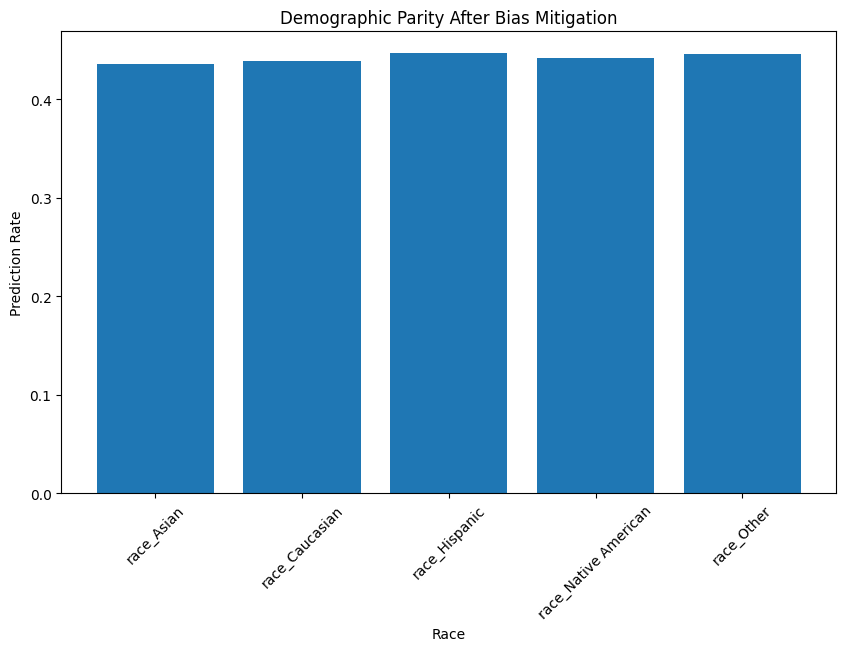

In [27]:
# Ensure y_pred_after is a Pandas Series
y_pred_after = pd.Series(y_pred_after, index=X_test_after.index)

races=[]
d_parity=[]
# Compute demographic parity again
demographic_parity_after = {}
race_columns = [col for col in df_after_mitigation.columns if "race_" in col]
for race_col in race_columns:
    race_df = X_test_after[X_test_after[race_col] == 1]

    if len(race_df) > 0:
        percentage = (y_pred_after.loc[race_df.index] == 1).sum() / len(race_df)
    else:
        percentage = 0

    #demographic_parity_after[race_col] = percentage
    d_parity.append(percentage)
    races.append(race_col)


print("Demographic Parity After Mitigation:")
for race, parity in demographic_parity_after.items():
    print(f"{race}: {parity:.2f}")

# Plot bar chart
plt.figure(figsize=(10, 6))
plt.bar(races,d_parity)
plt.xlabel("Race")
plt.ylabel("Prediction Rate")
plt.title("Demographic Parity After Bias Mitigation")
plt.xticks(rotation=45)
plt.show()


In [28]:
y_test_after.head()

,two_year_recid
26864,1
35367,0
34590,0
34614,1
27275,1


Equalized Odds

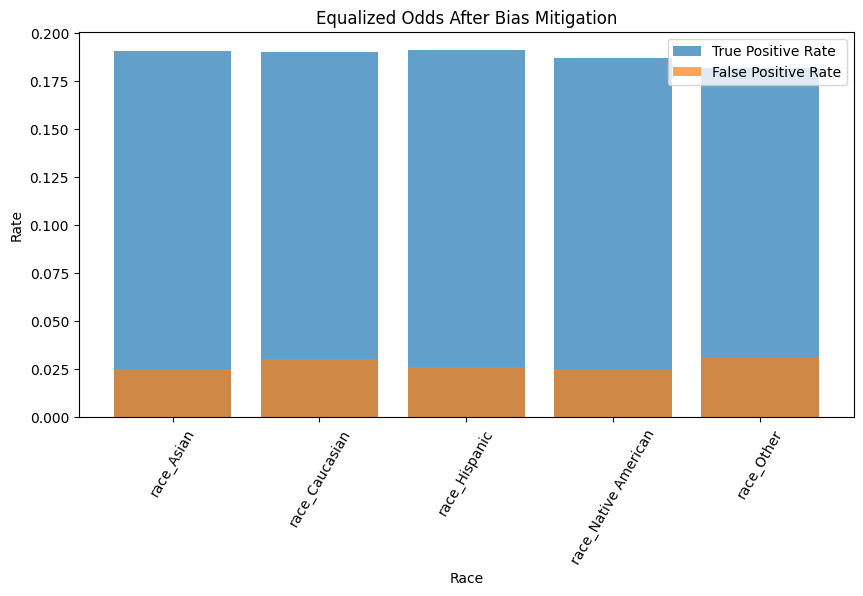

In [29]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Ensure y_pred_after is a pandas Series and remove NaN values
y_pred_after = pd.Series(y_pred_after, index=df_after_mitigation.index)
y_pred_after = y_pred_after.fillna(0).astype(int)  # Replace NaNs with 0 and convert to integer

tps_after = []
fps_after = []
races = []
prp=[]
race_columns = [col for col in df_after_mitigation.columns if "race_" in col]

for race_col in race_columns:
    race_df = df_after_mitigation[df_after_mitigation[race_col] == 1]  # Filter by race

    if len(race_df) == 0:
        continue  # Skip if no data for this race

    # Extract actual values (event column) and predictions
    actual = df_after_mitigation.loc[race_df.index, "event"].fillna(0).astype(int)  # Fix NaN
    predicted = y_pred_after.loc[race_df.index]

    # Ensure values are valid (only 0 or 1)
    actual = np.clip(actual, 0, 1)
    predicted = np.clip(predicted, 0, 1)

    # Compute confusion matrix safely
    tn, fp, fn, tp = confusion_matrix(actual, predicted).ravel()

    true_positive_rate = tp / (tp + fn) if (tp + fn) > 0 else 0
    false_positive_rate = fp / (fp + tn) if (fp + tn) > 0 else 0

    tps_after.append(true_positive_rate)
    fps_after.append(false_positive_rate)
    races.append(race_col)

#  Plot Equalized Odds
plt.figure(figsize=(10, 5))
plt.bar(races, tps_after, label="True Positive Rate", alpha=0.7)
plt.bar(races, fps_after, label="False Positive Rate", alpha=0.7)
plt.xlabel("Race")
plt.ylabel("Rate")
plt.title("Equalized Odds After Bias Mitigation")
plt.xticks(rotation=60)
plt.legend()
plt.show()


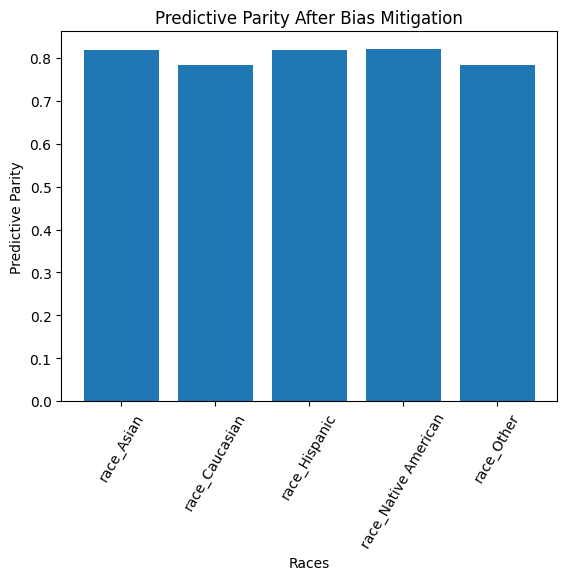

In [30]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Ensure y_pred_after is a pandas Series and remove NaN values
y_pred_after = pd.Series(y_pred_after, index=df_after_mitigation.index)
y_pred_after = y_pred_after.fillna(0).astype(int)  # Replace NaNs with 0 and convert to integer


races = []
prp_after=[]
race_columns = [col for col in df_after_mitigation.columns if "race_" in col]

for race_col in race_columns:
    race_df = df_after_mitigation[df_after_mitigation[race_col] == 1]  # Filter by race

    if len(race_df) == 0:
        continue  # Skip if no data for this race

    # Extract actual values (event column) and predictions
    actual = df_after_mitigation.loc[race_df.index, "event"].fillna(0).astype(int)  # Fix NaN
    predicted = y_pred_after.loc[race_df.index]

    # Ensure values are valid (only 0 or 1)
    actual = np.clip(actual, 0, 1)
    predicted = np.clip(predicted, 0, 1)

    # Compute confusion matrix safely
    tn, fp, fn, tp = confusion_matrix(actual, predicted).ravel()

    predictive_rate_parity= tp/(tp+fp) if tp+fp>0 else 0

    prp_after.append(predictive_rate_parity)
    races.append(race_col)


import matplotlib.pyplot as plt

plt.bar(races,prp_after)
plt.xlabel('Races')
plt.ylabel('Predictive Parity')
plt.xticks(rotation=60)
plt.title('Predictive Parity After Bias Mitigation')
plt.show()


## Fairness Constraints

In [31]:
df.columns

Index(['id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob',
       'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
       'juv_misd_count', 'juv_other_count', 'priors_count',
       'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number',
       'c_offense_date', 'c_arrest_date', 'c_days_from_compas',
       'c_charge_degree', 'c_charge_desc', 'is_recid', 'r_case_number',
       'r_charge_degree', 'r_days_from_arrest', 'r_offense_date',
       'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid',
       'is_violent_recid', 'vr_case_number', 'vr_charge_degree',
       'vr_offense_date', 'vr_charge_desc', 'type_of_assessment',
       'decile_score.1', 'score_text', 'screening_date',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date', 'in_custody', 'out_custody', 'priors_count.1',
       'start', 'end', 'event', 'two_year_recid'],
      dtype='object')

In [32]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime

In [70]:
def calculate_age(d):
    """
    Calculate age from date of birth.
    """
    today = datetime.today()
    return today.year - d.year - ((today.month, today.day) < (d.month, d.day))

def custom_loss(y_true, y_pred):
    """
    Custom loss function: Mean Squared Error with penalty for large deviations.
    """
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    penalty = tf.reduce_mean(tf.cast(tf.abs(y_true - y_pred) > 5, tf.float32)) * 10  # Additional penalty for errors > 5
    return mse + penalty

import tensorflow as tf

def fairness_loss_demographic_parity(y_true, y_pred):
    """
    Custom Keras loss that adds a penalty if
    |P(ŷ=1 | z=0) - P(ŷ=1 | z=1)| > ε (Demographic Parity).

    Expects y_true to have shape (batch_size, 2):
        y_true[:, 0] = actual label (assumed here to be in {1, -1})
        y_true[:, 1] = protected attribute z (in {0,1})
    y_pred is the raw (logit) output of the network.
    """
    # Hyperparameters
    epsilon = 0.05   # Allowable difference for fairness
    lambda_ = 4.0    # Fairness penalty weight

    # Separate out the protected attribute z
    z = y_true[:, 1]

    # Compute usual binary cross-entropy classification loss
    logits_squeezed = tf.squeeze(y_pred, axis=-1)  # Shape (batch_size,)
    y_pos = (y_true[:, 0] + 1) / 2.0  # Convert labels {1, -1} to {1, 0}
    classification_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(labels=y_pos, logits=logits_squeezed)
    )

    # Get predicted probabilities P(ŷ=1)
    p = tf.sigmoid(y_pred)

    # Mask for z=0
    mask0 = tf.equal(z, 0.0)
    # Mask for z=1
    mask1 = tf.equal(z, 1.0)

    # Extract the predicted probabilities in each subgroup
    p0 = tf.boolean_mask(p, mask0)
    p1 = tf.boolean_mask(p, mask1)

    # Compute means safely using tf.cond
    mean_p0 = tf.cond(
        tf.greater(tf.size(p0), 0),
        lambda: tf.reduce_mean(p0),
        lambda: tf.constant(0.0)
    )
    mean_p1 = tf.cond(
        tf.greater(tf.size(p1), 0),
        lambda: tf.reduce_mean(p1),
        lambda: tf.constant(0.0)
    )

    # Difference in average predicted probabilities across groups
    diff = mean_p0 - mean_p1

    # Fairness penalty: hinge function around [-ε, ε]
    penalty = tf.maximum(0.0, diff - epsilon) + tf.maximum(0.0, -epsilon - diff)

    # Final loss = classification_loss + λ * fairness_penalty
    return classification_loss + lambda_ * penalty


def fairness_loss(y_true, y_pred):
    """
    Custom Keras loss that adds a penalty if
    |P(ŷ=1 | z=0, y=-1) - P(ŷ=1 | z=1, y=-1)| > ε.

    Expects y_true to have shape (batch_size, 2):
        y_true[:, 0] = actual label (assumed here to be in {1, -1})
        y_true[:, 1] = protected attribute z (in {0,1})
    y_pred is the raw (logit) output of the network.
    """
    # Hyperparameters
    epsilon = 0.05   # the allowable difference
    lambda_ = 4.0    # how strongly we penalize fairness violations

    # Separate out the true labels and protected attribute
    y = y_true[:, 0]
    z = y_true[:, 1]

    # Convert labels {1, -1} -> {1, 0} for standard binary crossentropy
    y_pos = (y + 1) / 2.0  # Now y_pos in {0,1}

    # Compute usual binary cross-entropy classification loss
    # y_pred are logits, so we can use sigmoid_cross_entropy_with_logits
    logits_squeezed = tf.squeeze(y_pred, axis=-1)  # Now shape (batch_size,)
    classification_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(labels=y_pos, logits=logits_squeezed)
    )

    # Get predicted probabilities P(ŷ=1)
    p = tf.sigmoid(y_pred)

    # Mask for the subgroup z=0, y=-1
    mask0 = tf.logical_and(tf.equal(z, 0.0), tf.equal(y, -1.0))
    # Mask for the subgroup z=1, y=-1
    mask1 = tf.logical_and(tf.equal(z, 1.0), tf.equal(y, -1.0))

    # Extract the predicted probabilities in each subgroup
    p0 = tf.boolean_mask(p, mask0)
    p1 = tf.boolean_mask(p, mask1)

    # Use tf.cond to safely compute means if the masks are not empty
    mean_p0 = tf.cond(
        tf.greater(tf.size(p0), 0),
        lambda: tf.reduce_mean(p0),
        lambda: tf.constant(0.0)
    )
    mean_p1 = tf.cond(
        tf.greater(tf.size(p1), 0),
        lambda: tf.reduce_mean(p1),
        lambda: tf.constant(0.0)
    )

    # Difference in average predicted probabilities
    diff = mean_p0 - mean_p1

    # Fairness penalty = hinge around [-ε, ε]
    #   penalty = max(0, diff - ε) + max(0, -ε - diff)
    penalty = tf.maximum(0.0, diff - epsilon) + tf.maximum(0.0, -epsilon - diff)

    # Final loss = classification_loss + λ * fairness_penalty
    return classification_loss + lambda_ * penalty


def compute_demographic_parity(y_true, y_pred):
    """
    Computes the demographic parity difference:
    | P(ŷ=1 | z=0) - P(ŷ=1 | z=1) |

    Expects:
        - y_true: Tensor of shape (batch_size, 2)
          - y_true[:, 0] = actual label (ignored for DP)
          - y_true[:, 1] = protected attribute z (in {0,1})
        - y_pred: Raw (logit) output of the model (before applying sigmoid)

    Returns:
        - Demographic parity difference as a TensorFlow scalar.
    """
    # Extract protected attribute z
    z = y_true[:, 1]

    # Compute predicted probabilities P(ŷ=1)
    p = tf.sigmoid(y_pred)

    # Mask for the subgroup z=0
    mask0 = tf.equal(z, 0)
    # Mask for the subgroup z=1
    mask1 = tf.equal(z, 1)

    # Extract the predicted probabilities in each subgroup
    p0 = tf.boolean_mask(p, mask0)
    p1 = tf.boolean_mask(p, mask1)

    # Compute means safely using tf.cond to avoid empty slices
    mean_p0 = tf.cond(
        tf.greater(tf.size(p0), 0),
        lambda: tf.reduce_mean(p0),
        lambda: tf.constant(0.0)
    )
    mean_p1 = tf.cond(
        tf.greater(tf.size(p1), 0),
        lambda: tf.reduce_mean(p1),
        lambda: tf.constant(0.0)
    )

    # Compute absolute demographic parity difference
    demographic_parity = tf.abs(mean_p0 - mean_p1)

    return demographic_parity

def compute_accuracy(y_true, y_pred):
    """
    Computes the accuracy of a binary classifier.

    Expects:
        - y_true: Tensor of shape (batch_size, 2)
          - y_true[:, 0] = actual label (assumed to be in {1, -1})
          - y_true[:, 1] = protected attribute z (not used for accuracy)
        - y_pred: Raw (logit) output of the model (before applying sigmoid)

    Returns:
        - Accuracy as a TensorFlow scalar.
    """
    # Extract true labels (first column)
    y = y_true[:, 0]

    # Convert labels from {1, -1} to {1, 0} for comparison
    y_true_binary = (y + 1) / 2.0  # Convert to {0,1}

    # Compute predicted labels (after applying sigmoid and thresholding at 0.5)
    y_pred_binary = tf.cast(tf.sigmoid(y_pred) >= 0.5, tf.float32)

    # Compute accuracy
    correct_predictions = tf.equal(y_pred_binary, y_true_binary)
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

    return accuracy

In [34]:
data = df.rename(columns={
    'priors_count': 'history_violence',
    'juv_other_count': 'vocational_edu',  # Placeholder, adjust as needed
    'juv_misd_count': 'history_nc',
    'two_year_recid': 'risk_score'
})
race_mapping = {r: i + 1 for i, r in enumerate(df['race'].unique())}
data['race'] = df['race'].map(race_mapping)
data['c_offense_date'] = pd.to_datetime(data['c_offense_date'])
data['age_first'] = data['c_offense_date'].apply(calculate_age)
features = ['age', 'age_first', 'history_violence', 'vocational_edu', 'history_nc', 'race']
data = data.dropna(subset= features + ['risk_score'])
data.drop(['race'], axis=1)
X = data[features]
y = data['risk_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
z_train = X_train['race']
X_train.shape[0], X_test.shape[0]

(4844, 1211)

In [35]:
import numpy as np

# Suppose y_train and z_train are Pandas Series
# Convert each to a NumPy array and reshape to 2D
y_train_2d = y_train.values.reshape(-1, 1)
z_train_2d = z_train.values.reshape(-1, 1)
y_test_2d = y_test.values.reshape(-1, 1)
z_test_2d = X_test['race'].values.reshape(-1, 1)

# Now stack them horizontally to get shape (n_samples, 2)
y_train_combined = np.hstack([y_train_2d, z_train_2d])
y_test_combined = np.hstack([y_test_2d, z_test_2d])

### Loss Function = Mean Squared Error

In [36]:
model_keras = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [58]:
model_keras.compile(optimizer='adam', loss='mean_squared_error')
model_keras.fit(X_train, y_train_combined, epochs=20, batch_size=16, verbose=1)

Epoch 1/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.3256
Epoch 2/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.3050
Epoch 3/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.3362
Epoch 4/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.3184
Epoch 5/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.3307
Epoch 6/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.3243
Epoch 7/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.3440
Epoch 8/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.3411
Epoch 9/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.2905
Epoch 10/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.3107
Epoch 11/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.3295
Epoch 12/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.3197
Epoch 13/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.3246
Epoch 14/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.3352
Epoch 15/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - lo

In [59]:
loss = model_keras.evaluate(X_test, y_test_combined)
print(loss)

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3355
1.3485338687896729


In [67]:
acc = compute_accuracy(y_test_combined, model_keras.predict(X_test))
print(acc)

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
tf.Tensor(0.4632535, shape=(), dtype=float32)


In [71]:
compute_demographic_parity(y_test_combined, model_keras.predict(X_test))

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


<tf.Tensor: shape=(), dtype=float32, numpy=0.6824489235877991>

### Loss Function = Mean Squared Error with Fairness Penalty

In [63]:
fair_model_keras = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [56]:
fair_model_keras.compile(optimizer='adam', loss=fairness_loss_demographic_parity)
fair_model_keras.fit(X_train, y_train_combined, epochs=20, batch_size=16, verbose=1)

Epoch 1/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.4628
Epoch 2/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9358
Epoch 3/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7444
Epoch 4/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6918
Epoch 5/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6825
Epoch 6/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6763
Epoch 7/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6729
Epoch 8/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6926
Epoch 9/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6993
Epoch 10/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6874
Epoch 11/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6668
Epoch 12/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6783
Epoch 13/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6846
Epoch 14/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6834
Epoch 15/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - lo

In [57]:
loss = fair_model_keras.evaluate(X_test, y_test_combined)
print(f"loss: {loss}")

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6424
loss: 0.6738175749778748


In [64]:
acc_after = compute_accuracy(y_test_combined, fair_model_keras.predict(X_test))
print(acc_after)

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
tf.Tensor(0.0, shape=(), dtype=float32)


In [72]:
compute_demographic_parity(y_test_combined, fair_model_keras.predict(X_test))

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


<tf.Tensor: shape=(), dtype=float32, numpy=0.0007968870340846479>